## 1. Requirements

In [1]:
# https://github.com/Harry24k
import numpy as np
import json

# basic torch library for your datatype, nn structure, optimizers grad update?, dataset abstract
import torch
import torch.nn as nn
import torch.optim as optim # grad and update
import torch.utils.data as Data # dataset of tensors and labels

# torchvision includes popular dataset, model and image transformation tools
import torchvision.utils  
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt # plot
%matplotlib inline

## 2. Set Args

In [15]:
use_cuda = False # no cuda on Mac OS T T
device = torch.device("cuda" if use_cuda else "cpu")

In [16]:
device

device(type='cpu')

## 3. Prepare Data

In [32]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json")) # load json file to read class:index dictionary
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))] # str(index):[someUnknownNumber, Label]; index to label

In [35]:
idx2label

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

In [18]:
# torchvision.transforms use

transform = transforms.Compose([
    transforms.Resize((299, 299)), # Inception V3和Xception需要299×299像素输入 
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [36]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform) # torchvision.datasets.ImageFolder
    old_classes = old_data.classes # it is related to datasets.ImageFolder
    # old_classes is depending on your local datasets
    
    
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i 
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x])) # lambda x : 
    
    # as for target_transform, it mapps the old index to the new index. here the new index is the Imagenet index.
    
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx # not used later
    
    # initiate -> classes as a list of classes -> class_to_index as dictionary mapping from class label to index

    return new_data

In [37]:
# root is where you put your image, transform is how you resize your image, 
# custom_label is your index=>label in a list.
# image_folder_custom_label is written by the author of this repo, not specified by PyTorch.
normal_data = image_folder_custom_label(root = './data/imagenet', transform = transform, custom_label = idx2label)

# normal_data is a ImageFolder class and batch_size B is only 1 and does not need shuffle.
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)


['giant_panda']


In [46]:
def imshow(img, title): # how to show an image with some title
    npimg = img.numpy()     # torchvision.utils.make_grid: make a grid of images img is a tensor numpy() transfroms it into numpy array
    fig = plt.figure(figsize = (5, 15)) # matplotlib.plt.figure
    
    # tensor is C H W while numpy is H W C (height_pos width_pos channels)
    plt.imshow(np.transpose(npimg,(1,2,0))) # from torch tensor to numpy array
    plt.title(title) # give a name
    plt.show() # show the image

True Image & True Label


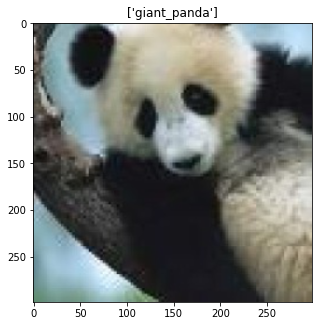

In [55]:
normal_iter = iter(normal_loader) # Python iter() function returns an iterator for the given object
images, labels = normal_iter.next() # use next to call iter one and one more time but here only the first next which means
# only one panda here to show

print("True Image & True Label")

# if normalize is true, shift the image to the range(0,1)
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels]) # image, show
# imshow(torchvision.utils.make_grid(images, normalize=Tr), [normal_data.classes[i] for i in labels])

## 4. Download the Inception v3

In [25]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context


#ssl verification

#download model and load it into CPU instead of GPU T T

model = models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


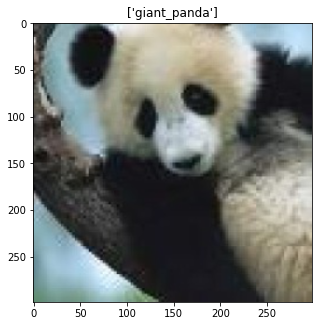

Accuracy of test text: 100.000000 %


In [26]:
print("True Image & Predicted Label")

model.eval()

# what does model.eval() do in pytorch?

#answer: sets the module in evaluation mode: only on certain modules. training/evaluation mode. they might be affected e.g. dropout batchnorem etc.


correct = 0
total = 0 # only one here  counter


for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1) # the maximum torch data; pre for predict; _ for index omitted
    
    total += 1 # total+1
    correct += (pre == labels).sum() # .sum() transfer true to 1 false to 0
    
    # move all model parameters and buffers to the CPU by cpu()
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 5. Adversarial Attack

$$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$$
* $S$ : a set of allowed perturbations

In [27]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    # original image
    ori_images = images.data
        
    # iteration times 40: iterative PGD instead of FGSM
    for i in range(iters) :    
        images.requires_grad = True # True if gradients need to be computed for this Tensor
        outputs = model(images)

        model.zero_grad() # sets gradients of all model parameters to zero
        cost = loss(outputs, labels).to(device) # 
        cost.backward() # computes the gradient of current tensor using the chain rule.

        
        # here we do x(t+1) = x(t) +  alpha sign(grad_over_image(L)) 
        adv_images = images + alpha*images.grad.sign() # core
        
        # projection clamp
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        
        # image (0,1) clamp
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_() # does not require grad by detach() 
            
    return images

Attack Image & Predicted Label


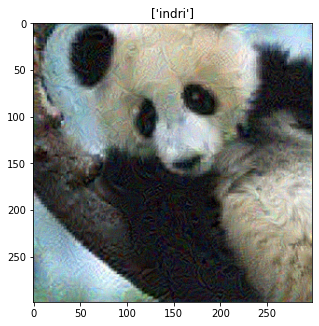

Accuracy of test text: 0.000000 %


In [56]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = pgd_attack(model, images, labels)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

In [31]:
total

1